## Data check

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (128, 5513)


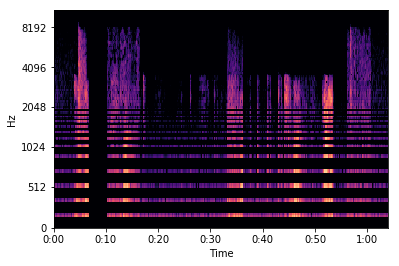

In [2]:
import librosa.display
from td_utils import *
%matplotlib inline

audio_dir = os.path.join('.','data','train_audios')
wav_file = 'mix_0.wav'
fullname = os.path.join(audio_dir, wav_file)

x = graph_spectrogram(fullname)
_, data = get_wav_info(fullname)
print("Time steps in audio recording before spectrogram", data.shape)
print("Time steps in input after spectrogram", x.shape)

librosa.display.specshow(x, sr=44100, x_axis='time', y_axis='mel')

In [3]:
data.shape
Tx = x.shape[1]     # 스펙토그램 길이
n_freq = x.shape[0] # 스펙토그램 높이
Ty = 1375           # 아웃풋 길이

# DataLoader

with keras

## Train

In [ ]:
X, Y 

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

In [ ]:
def make_model(input_shape):
    
    X_input = Input(shape = input_shape)
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)         # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                   # ReLu activation
    X = Dropout(0.8)(X)                                         # dropout (use 0.8)

    X = GRU(units = 128, return_sequences = True)(X)            # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                         # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization

    X = GRU(units = 128, return_sequences = True)(X)            # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                         # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Dropout(0.8)(X)                                         # dropout (use 0.8)

    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)    # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    return model  

In [ ]:
model = make_model(input_shape = (Tx, n_freq))

In [ ]:
model.summary()

In [ ]:
model = load_model('./models/tr_model.h5')

In [ ]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [ ]:
model.fit(X, Y, batch_size = 5, epochs=1)

In [ ]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

# Real Time?

In [ ]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [ ]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

In [ ]:
filename = "./raw_data/dev/1.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

In [ ]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

Once you've uploaded your audio file to Coursera, put the path to your file in the variable below.

In [ ]:
your_filename = "audio_examples/my_audio.wav"

In [ ]:
preprocess_audio(your_filename)
IPython.display.Audio(your_filename) # listen to the audio you uploaded 

Finally, use the model to predict when you say activate in the 10 second audio clip, and trigger a chime. If beeps are not being added appropriately, try to adjust the chime_threshold.

In [ ]:
chime_threshold = 0.5
prediction = detect_triggerword(your_filename)
chime_on_activate(your_filename, prediction, chime_threshold)
IPython.display.Audio("./chime_output.wav")